# Beiwe Homestay Data from GPS Traces
Peter provided the homestay data from the GPS traces and this notebook just helps take a look at it and process it for later use.

In [69]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [70]:
import sys
import os
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Import
We have the files stored in the `interim` directory so we can import them by participant. Each participant has a pre- and post-move file _if_ they have data from these periods. 

In [71]:
data_dir = "../"
data = pd.DataFrame()
for file in os.listdir(f"{data_dir}data/interim/pre_post_move_homestay/"):
    if file.split("_")[0] == "homestay":
        temp = pd.read_csv(f"{data_dir}data/interim/pre_post_move_homestay/{file}",parse_dates=["start","end"],infer_datetime_format=True)
        temp = temp.iloc[:,1:]
        temp["beiwe"] = file.split("_")[1]
        temp["when"] = file.split("_")[-1].split(".")[0]
        data = data.append(temp)

# Inspection
We can look at a few derivatives.

In [72]:
data["t"] = (data["end"] - data["start"]).dt.total_seconds()

## Comparing Lat/Long from Beiwe to Provided Address

In [73]:
# Importing the data
raw_info = pd.read_excel("../data/raw/utx000/admin/id_crossover.xlsx",sheet_name="beacon")
info = raw_info[["beiwe","lat","long","lat2","long2"]]
# filtering dataset
add = data.groupby(["beiwe","when"]).median().reset_index()
add.rename({"home.lat":"lat","home.long":"long"},axis="columns",inplace=True)
# merging
merged = add.merge(right=info,on="beiwe",suffixes=["_peter","_hagen"])

In [74]:
def plot_bar(df):
    """"""
    labels = []
    # pre and no move
    df_pre = df[df["when"].isin(["premove","nomove"])]
    lat_diff = abs(df_pre["lat_hagen"] - df_pre["lat_peter"])
    long_diff = abs(df_pre["long_hagen"] - df_pre["long_peter"])
    labels += list(df_pre["beiwe"].values)
    # post
    df_post = df[df["when"].isin(["postmove"])]
    lat_diff = lat_diff.append(abs(df_post["lat2"] - df_post["lat_peter"]))
    long_diff = long_diff.append(abs(df_post["long2"] - df_post["long_peter"]))
    labels += list(df_post["beiwe"].values)

    x = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots(figsize=(16,6))
    rects1 = ax.bar(x - width/2, lat_diff, width, label='Lat', color="cornflowerblue", edgecolor="black")
    rects2 = ax.bar(x + width/2, long_diff, width, label='Long', color="seagreen", edgecolor="black")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Absolute Difference in Coordinates')
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=-30,ha="left")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.legend()

    plt.show()


## Getting Move-Out Dates

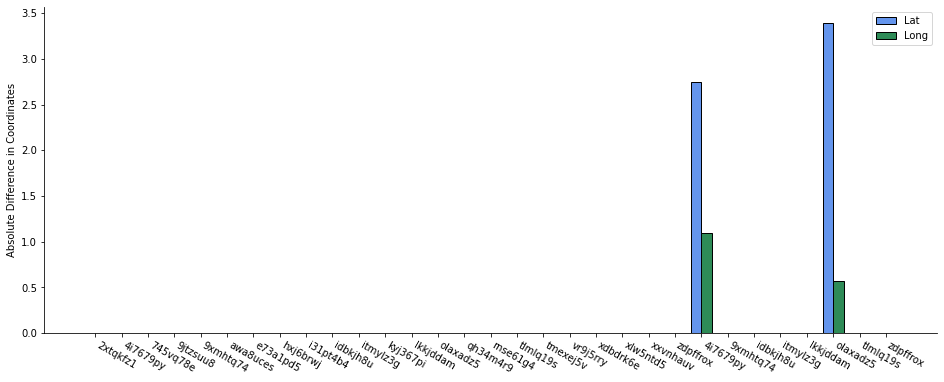

In [75]:
plot_bar(merged)

In [76]:
move = raw_info[["beiwe","original_move"]]
move.dropna(inplace=True)
move.rename({"original_move":"move"},axis="columns",inplace=True)
#move.to_csv("../data/raw/utx000/admin/move_dates-ux_s20.csv",index=False)

# Saving

In [77]:
data.to_csv("../data/processed/beiwe-homestay-ux_s20.csv")